Deep Neural Network

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
# from utils.helper import fn_plot_tf_hist

In [3]:
### ----------------------
### global variables
### ----------------------

import random

RANDOM_STATE = 24
np.random.RandomState(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)


TEST_SIZE = 0.2
ALPHA = 0.001 # LEARNING RATE
EPOCHS = 2000  # NUMBER OF ITERATIONS
BATCH_SIZE = 256

PATIENCE = 20
LR_FACTOR = 0.1
LR_PATIENCE = 10

# input and output directories
inpDir = '../../input'
outDir = '../output'

params = {
    'legend.fontsize': 'medium',
    'figure.figsize': (10, 6),
    'axes.labelsize': 'medium',
    'axes.titlesize':'large',
    'xtick.labelsize':'medium',
    'ytick.labelsize':'medium'
}

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')

In [ ]:
def fn_plot_tf_hist(hist_df):

    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: accuracy
            column 1: loss
            column 2: val_accuracy
            column 3: val_loss
            While plotting columns are accessed by index
            so that even if the column names are different it will not throw exceptions.
    '''

    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm

    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y4] == hist_df[y4].min()]

    ax = axes[0]

    hist_df.plot(y = [y2,y4], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = '{:s}: \n  train: {:6.4f}\n   test: {:6.4f}'
    txtstr = txtFmt.format(y2.capitalize(),
                           hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0] + offset), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3)

    ax.set_xlabel('Epochs')
    ax.set_ylabel(y2.capitalize())
    ax.set_title('Errors')
    ax.grid(True)
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y1, y3], ax = ax, colormap=CMAP)

    # little beautification
    txtFmt = '{:s}: \n  train: {:6.4f}\n  test:  {:6.4f}'
    txtstr = txtFmt.format(y1.capitalize(),
                           hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0]-offset), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow


    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3)

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.grid(True)
    ax.legend(loc = 'lower left')

    plt.tight_layout()

def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth
        y_pred : Predictions
        labels : labels in a dictonary
                  {0: 'Goal Keeper',
                  1: 'Defender',
                  2: 'Mid-Fielder',
                  3: 'Forward'}

    '''

    cm  = confusion_matrix(y_true, y_pred)

    if isinstance(labels, dict):
        display_labels = labels.values()
    else:
        display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)

    fig, ax = plt.subplots(figsize = (4,4))

    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

    # Disable the grid
    ax.grid(False)

    plt.show()


# Load Data

# EDA
1. Remove Null from Position
2. Read unique values from the columns

In [ ]:
data_df = pd.read_csv("fifa_2019.csv")
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [ ]:
x_train_cols = data_df.drop(["label"], axis = 1)
y_train_cols = data_df["label"].to_numpy()
x_train_cols.shape, y_train_cols.shape

((60000, 784), (60000,))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_train_cols,
                                                    y_train_cols,
                                                    test_size = 0.2,
                                                    random_state = 24,
                                                    stratify = y_train_cols)

In [ ]:
sc = StandardScaler()
x_train = sc.fit_transform()

In [4]:
torch.cuda.is_available()

True

In [5]:
import torch.version

torch.version.cuda

'12.1'

In [6]:
torch.cuda.get_device_name(torch.cuda.current_device())

'Tesla T4'

In [ ]:
device = 'cuda'

In [ ]:
test_df = pd.read_csv("fashion-mnist_test.csv")
x_valid = test_df.drop("label", axis = 1).to_numpy()
y_valid = test_df["label"].to_numpy()

x_train.shape, x_test.shape, x_valid.shape, y_train.shape, y_test.shape, y_valid.shape

((48000, 784), (12000, 784), (10000, 784), (48000,), (12000,), (10000,))

In [ ]:
48000/400

120.0

In [ ]:
# Nromalize the data between [0, 1]

# x_train = x_train / 255.0

# x_test = x_test / 255.0

# x_valid = x_valid / 255.0

In [ ]:
class_names = {0 : "T-shirt",
               1 : "Trousers",
               2 : "long sleeves",
               3 : "dress",
               4 : "hoodie",
               5 : "sandle",
               6 : "shirt",
               7 : "sneaker",
               8 : "bag",
               9 : "boot"}

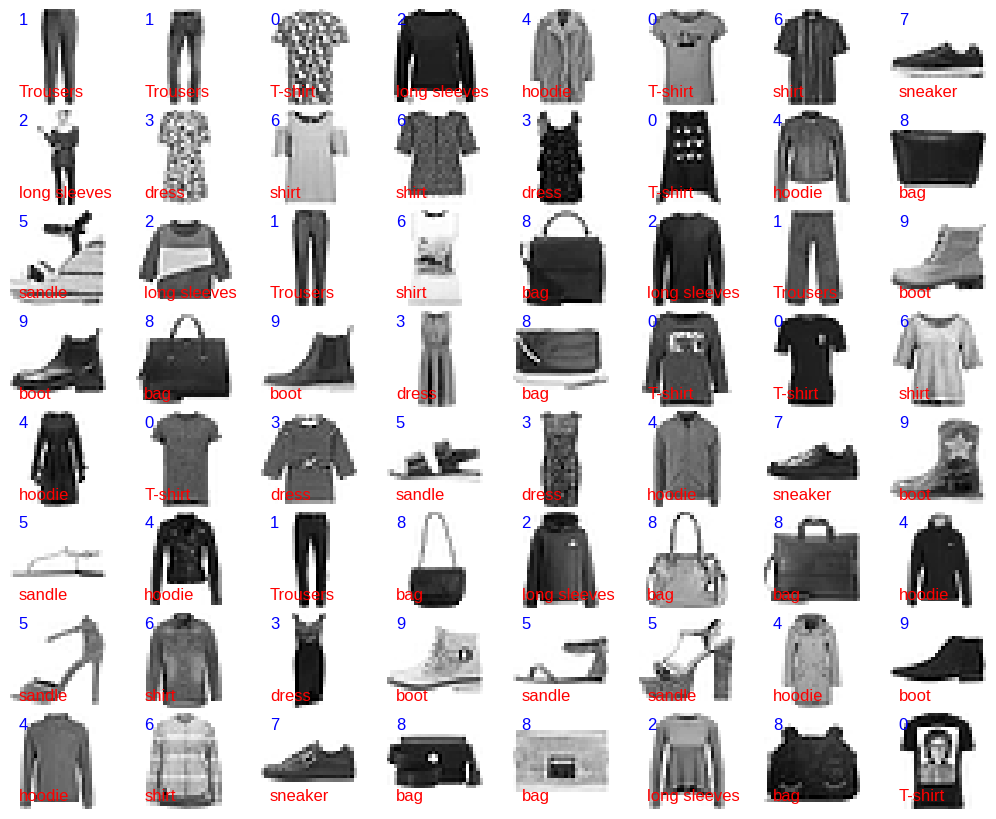

In [ ]:
n_rows = 8 # Number of rows in grid
n_cols = 8 # Number of columns in grid

# Randomly sample n_rows * n_cols images from dataset
plot_df= data_df.sample(n = n_rows *  n_cols)

# create new figure with larger grid
fig = plt.figure(figsize = (10, 8))

# adjust spacing between subplots to eliminate gaps
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

# subplot index
i = 0

# Iterate on each row
for idx, row in plot_df.iterrows():
    i += 1  # Increment subplot index.

    # reshape the row values (excluding the first column) into a 28 x 28 matrix
    image = row.values[1:].reshape(28, 28)

    # add a subplot to the figure at the 'i'th position in the grid
    ax = fig.add_subplot(n_rows, n_cols, i, xticks = [], yticks = [])

    # display the image on the subplot using a binary colormap
    ax.imshow(image, cmap = plt.cm.binary, interpolation = "nearest")

    # add the numeric label of the image in blue text at a specific position
    ax.text(2, 4, str(row.iloc[0]), color = "b", fontsize = 12)

    # add the class name of the image in red text below the nmeric label
    ax.text(2, 25, class_names[row.iloc[0]], color = "r", fontsize = 12)

# display the entire grid of images
plt.show()

In [ ]:
# Tensor slices

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))

In [ ]:

train_shape = x_train.shape
test_shape = x_test.shape
valid_shape = x_valid.shape

In [ ]:
import gc
del data_df, test_df, x_train_cols, y_train_cols,
gc.collect()
gc.collect()
gc.collect()

0

In [ ]:
# shuffle and batch the dataset
# - By chaining these operations (suffle and batch) the dataset is first huffled
# - and then divided into batches, making it ready for training.
train_ds = train_ds.shuffle(buffer_size = train_shape[0]).batch(BATCH_SIZE)

test_ds = test_ds.shuffle(buffer_size = test_shape[0]).batch(BATCH_SIZE)

valid_ds = valid_ds.shuffle(buffer_size = valid_shape[0]).batch(BATCH_SIZE)

In [ ]:
## Optimize for performance,
# Cache the data to avoid redundant processing
# Repeat the dataset for multiple epochs
# prefetch data to overlap preprocessing and model execution:

train_ds = train_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

# Prepare model

### Functional API

In [ ]:
# y_pred = model.predict(x_train)
# accuracy_score(y_true = y_train,
#                y_pred = y_pred.argmax(axis = 1))

Batch Normalization

In [ ]:
DOR1 = 0.3
DOR2 = 0.25
DOR3 = 0.2
DOR4 = 0.15
DOR5 = 0.10
DOR6 = 0.05

initializer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

optimizer = tf.keras.optimizers.Adam(learning_rate = ALPHA)

# Define regularizer
regularizer = tf.keras.regularizers.L2(0.05)

inputs = tf.keras.Input(shape = (train_shape[1],), name = "input")

# Set 1
x = tf.keras.layers.Dense(640,
                          kernel_initializer = initializer,
                          name = "fc_1")(inputs)

x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Activation(activation = 'leaky_relu')(x)

x = tf.keras.layers.Dropout(rate = DOR1)(x)

# Set 2
x = tf.keras.layers.Dense(320,
                          kernel_initializer = initializer,
                          name = "fc_2")(x)

x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Activation(activation = 'leaky_relu')(x)

x = tf.keras.layers.Dropout(rate = DOR2)(x)

# Set 3
x = tf.keras.layers.Dense(160,
                          kernel_initializer = initializer,
                          name = "fc_3")(x)

x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Activation(activation = 'leaky_relu')(x)

x = tf.keras.layers.Dropout(rate = DOR3)(x)

# Set 4
x = tf.keras.layers.Dense(80,
                          kernel_initializer = initializer,
                          name = "fc_4")(x)

x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Activation(activation = 'leaky_relu')(x)

x = tf.keras.layers.Dropout(rate = DOR4)(x)

# Set 5
x = tf.keras.layers.Dense(40,
                          kernel_initializer = initializer,
                          name = "fc_5")(x)

x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Activation(activation = 'leaky_relu')(x)

x = tf.keras.layers.Dropout(rate = DOR5)(x)


# Set 6
x = tf.keras.layers.Dense(20,
                          kernel_initializer = initializer,
                          name = "fc_6")(x)

x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Activation(activation = 'leaky_relu')(x)

x = tf.keras.layers.Dropout(rate = DOR6)(x)


outputs = tf.keras.layers.Dense(10, name = "output")(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs, name = "MNIST")

In [ ]:
model.summary()

Model: "MNIST"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 640)                 │         502,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_56               │ (None, 640)                 │           2,560 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_59 (Activation)           │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_56 (Dropout)                 │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 320)                 │         205,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_57               │ (None, 320)                 │           1,280 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_60 (Activation)           │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_57 (Dropout)                 │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_3 (Dense)                         │ (None, 160)                 │          51,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_58               │ (None, 160)                 │             640 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_61 (Activation)           │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_58 (Dropout)                 │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_4 (Dense)                         │ (None, 80)                  │          12,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_59               │ (None, 80)                  │             320 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_62 (Activation)           │ (None, 80)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_59 (Dropout)                 │ (None, 80)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_5 (Dense)                         │ (None, 40)                  │           3,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_60               │ (None, 40)                  │             160 │
│ (BatchNormalization)                 │                             │              

 Total params: 781,070 (2.98 MB)

 Trainable params: 778,550 (2.97 MB)

 Non-trainable params: 2,520 (9.84 KB)

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

optimizer = tf.keras.optimizers.Adam(learning_rate = ALPHA)

model.compile(optimizer = optimizer,
              loss = loss_fn,
              metrics = ["accuracy"])


In [ ]:
chtptPath = os.path.join(os.getcwd(), "all_in.keras")
chkpt_cb = tf.keras.callbacks.ModelCheckpoint(
    chtptPath,
    monitor = "val_loss",
    verbose = 2,
    save_best_only = True,
)

es_cb = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    verbose = 2,
    patience = PATIENCE,
    restore_best_weights = True,
)

LR_FACTOR = 0.1
lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = "val_loss",
    vactor = LR_FACTOR,
    verbose = 2,
    patience = LR_PATIENCE,
)

In [ ]:
history = model.fit(train_ds,
                    validation_data = test_ds,
                    verbose = 2,
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    callbacks = [chkpt_cb, es_cb, lr_cb])

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.53619, saving model to /content/all_in.keras
188/188 - 14s - 75ms/step - accuracy: 0.7696 - loss: 0.8443 - val_accuracy: 0.8147 - val_loss: 0.5362 - learning_rate: 0.0010
Epoch 2/100

Epoch 2: val_loss improved from 0.53619 to 0.44628, saving model to /content/all_in.keras
188/188 - 8s - 44ms/step - accuracy: 0.8389 - loss: 0.5003 - val_accuracy: 0.8406 - val_loss: 0.4463 - learning_rate: 0.0010
Epoch 3/100

Epoch 3: val_loss improved from 0.44628 to 0.41600, saving model to /content/all_in.keras
188/188 - 11s - 60ms/step - accuracy: 0.8541 - loss: 0.4374 - val_accuracy: 0.8497 - val_loss: 0.4160 - learning_rate: 0.0010
Epoch 4/100

Epoch 4: val_loss improved from 0.41600 to 0.37780, saving model to /content/all_in.keras
188/188 - 9s - 50ms/step - accuracy: 0.8627 - loss: 0.4006 - val_accuracy: 0.8627 - val_loss: 0.3778 - learning_rate: 0.0010
Epoch 5/100

Epoch 5: val_loss improved from 0.37780 to 0.36746, saving model to /content/

In [ ]:
y_pred = model.predict(x_train)
accuracy_score(y_true = y_train,
               y_pred = y_pred.argmax(axis = 1))

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step


0.9530625

In [ ]:
y_pred_val = model.predict(x_valid)
accuracy_score(y_true = y_valid,
               y_pred = y_pred_val.argmax(axis = 1))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


0.9036

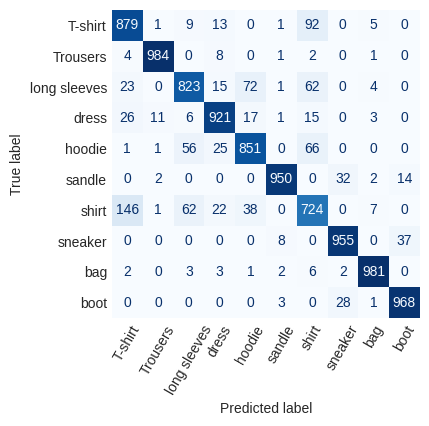

In [ ]:
cm = confusion_matrix(y_true = y_valid,
                      y_pred = y_pred_val.argmax(axis = 1))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_names.values())
fig, ax = plt.subplots(figsize = (4, 4))
disp.plot(ax = ax, cmap = "Blues", colorbar = False)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 60)
ax.grid(False)

In [ ]:
hist_df = pd.DataFrame(history.history)
display(hist_df.head())

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.769604,0.844338,0.814667,0.536186,0.001
1,0.838875,0.500253,0.840583,0.446280,0.001
2,0.854104,0.437363,0.849667,0.415996,0.001
3,0.862688,0.400551,0.862667,0.377803,0.001
4,0.870333,0.377123,0.869667,0.367462,0.001


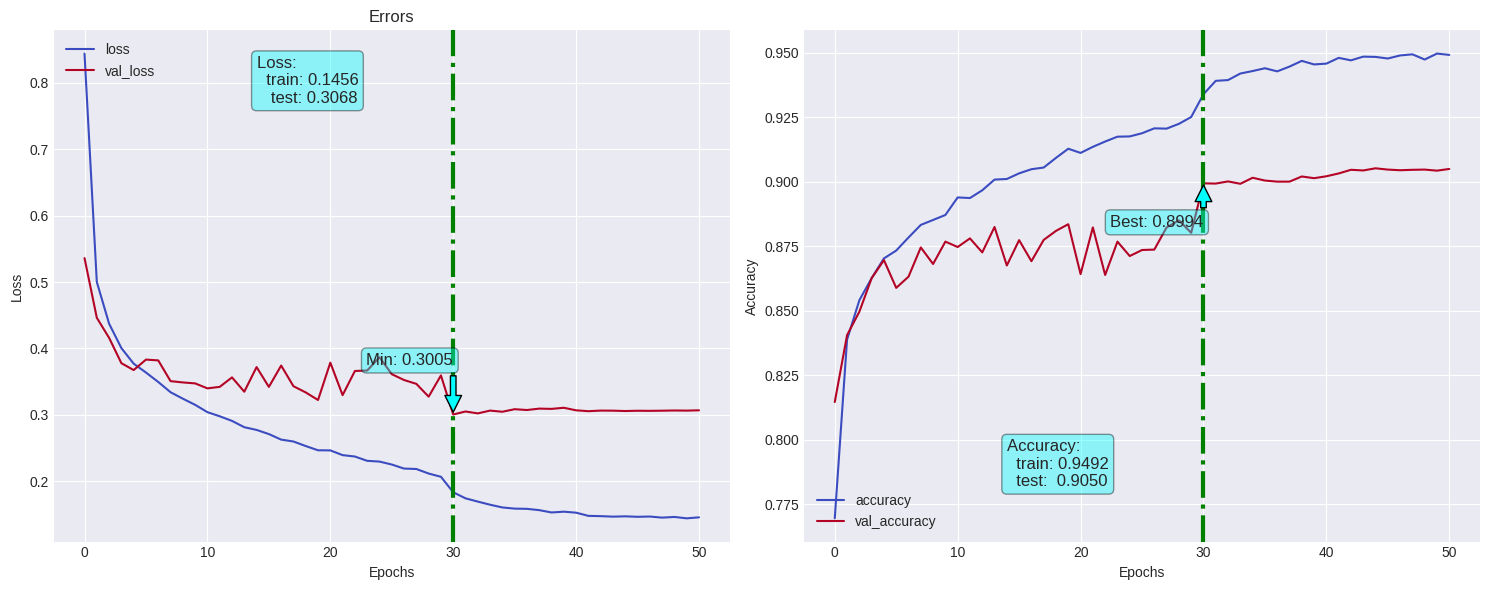

In [ ]:
fn_plot_tf_hist(hist_df = hist_df)